# setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install umap-learn

In [3]:
import pickle
import numpy as np

# import umap
import matplotlib.pyplot as plt

In [4]:
import torch

# load weight mats

In [5]:
# Define the path to your pickle file in Google Drive
file_path = '/content/drive/MyDrive/sae_files/ts-1L-21M_Wdec.pkl'  # Change the path if necessary

# Load the weight matrix from the pickle file
with open(file_path, 'rb') as f:
    weight_matrix_np = pickle.load(f)

# Optionally, check the shape of the loaded weight matrix
print(weight_matrix_np.shape)

torch.Size([16384, 1024])


In [6]:
weight_matrix_np = weight_matrix_np.detach().numpy()

In [7]:
# Define the path to your pickle file in Google Drive
file_path = '/content/drive/MyDrive/sae_files/gpt2sm_mlp0_Wdec.pkl'  # Change the path if necessary

# Load the weight matrix from the pickle file
with open(file_path, 'rb') as f:
    weight_matrix_2 = pickle.load(f)

# Optionally, check the shape of the loaded weight matrix
print(weight_matrix_2.shape)

torch.Size([32768, 768])


In [8]:
weight_matrix_2 = weight_matrix_2.detach().numpy()

# load sae f actvs

In [56]:
file_path = '/content/drive/MyDrive/sae_files/fActs_ts_1L_21M_anySamps_v1.pkl'
with open(file_path, 'rb') as f:
    feature_acts_model_A = pickle.load(f)

In [57]:
file_path = '/content/drive/MyDrive/sae_files/fActs_GPT2sm_MLP0.pkl'
with open(file_path, 'rb') as f:
    feature_acts_model_B = pickle.load(f)

In [11]:
feature_acts_model_A.shape

torch.Size([500, 128, 16384])

In [12]:
feature_acts_model_B.shape

torch.Size([500, 128, 32768])

In [165]:
first_dim_reshaped = feature_acts_model_A.shape[0] * feature_acts_model_A.shape[1]
reshaped_activations_A = feature_acts_model_A.reshape(first_dim_reshaped, feature_acts_model_A.shape[-1]).cpu()
reshaped_activations_B = feature_acts_model_B.reshape(first_dim_reshaped, feature_acts_model_B.shape[-1]).cpu()

In [14]:
reshaped_activations_B.shape

torch.Size([64000, 32768])

In [167]:
reshaped_activations_A = reshaped_activations_A[0:20000, :]
reshaped_activations_B = reshaped_activations_B[0:20000, :]
reshaped_activations_B = reshaped_activations_B[:, :16384]
reshaped_activations_B.shape

torch.Size([20000, 16384])

In [33]:
del feature_acts_model_B
del feature_acts_model_A
torch.cuda.empty_cache()

# load feature labels

## load

In [ ]:
import json
with open('feature_top_samps_lst_1L_16k.json', 'rb') as f:
    feat_snip_dict = json.load(f)

In [ ]:
with open('feature_top_samps_lst_2L_MLP0_16k.json', 'rb') as f:
    feat_snip_dict_2 = json.load(f)

In [ ]:
import re

def extract_tagged_word(s):
    # Define the regex pattern to match the tagged word
    pattern = r'\[bold u dark_orange\](.*?)\[/\]'

    # Search for the pattern in the string
    match = re.search(pattern, s)

    # If a match is found, return the captured group (the word inside the tags)
    if match:
        return match.group(1)
    else:
        return None

In [ ]:
fList_model_A = []
for feat_dict in feat_snip_dict:
    # text = feat_dict['strings'][0]
    # result = extract_tagged_word(text)
    # fList_model_A.append(result)
    out_str = ''
    for text in feat_dict['strings']:
        result = extract_tagged_word(text)
        out_str += result + ', '
    fList_model_A.append(out_str)

In [ ]:
fList_model_B = []
for feat_dict in feat_snip_dict_2:
    out_str = ''
    for text in feat_dict['strings']:
        result = extract_tagged_word(text)
        out_str += result + ', '
    fList_model_B.append(out_str)

## save spliced labels

In [ ]:
with open('fList_model_A.pkl', 'wb') as f:
    pickle.dump(fList_model_A, f)
with open('fList_model_B.pkl', 'wb') as f:
    pickle.dump(fList_model_B, f)

In [ ]:
from google.colab import files
files.download('fList_model_A.pkl')
files.download('fList_model_B.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
with open('fList_model_A.pkl', 'rb') as f:
    fList_model_A = pickle.load(f)
with open('fList_model_B.pkl', 'rb') as f:
    fList_model_B = pickle.load(f)

# load corr

In [ ]:
import pickle
with open('highest_corr_inds_1L_2L_MLP0_16k_30k_relu.pkl', 'rb') as f:
    highest_correlations_indices_v1 = pickle.load(f)
with open('highest_corr_vals_1L_2L_MLP0_16k_30k_relu.pkl', 'rb') as f:
    highest_correlations_values_v1 = pickle.load(f)

# corr mat

## get all actv corrs

In [15]:
def find_all_highest_correlations(reshaped_activations_A, reshaped_activations_B):
    # Ensure tensors are on GPU
    if torch.cuda.is_available():
        reshaped_activations_A = reshaped_activations_A.to('cuda')
        reshaped_activations_B = reshaped_activations_B.to('cuda')

    # Normalize columns of A
    mean_A = reshaped_activations_A.mean(dim=0, keepdim=True)
    std_A = reshaped_activations_A.std(dim=0, keepdim=True)
    normalized_A = (reshaped_activations_A - mean_A) / (std_A + 1e-8)  # Avoid division by zero

    # Normalize columns of B
    mean_B = reshaped_activations_B.mean(dim=0, keepdim=True)
    std_B = reshaped_activations_B.std(dim=0, keepdim=True)
    normalized_B = (reshaped_activations_B - mean_B) / (std_B + 1e-8)  # Avoid division by zero

    # Compute correlation matrix
    correlation_matrix = torch.matmul(normalized_A.t(), normalized_B) / normalized_A.shape[0]

    # Handle NaNs by setting them to -inf
    correlation_matrix = torch.where(torch.isnan(correlation_matrix), torch.tensor(float('-inf')).to(correlation_matrix.device), correlation_matrix)

    # Get the highest correlation indices and values
    highest_correlations_values, highest_correlations_indices = correlation_matrix.max(dim=0)

    # Move results back to CPU
    highest_correlations_indices = highest_correlations_indices.cpu().numpy()
    highest_correlations_values = highest_correlations_values.cpu().numpy()

    return highest_correlations_indices, highest_correlations_values

## pair A with B

In [171]:
highest_correlations_indices_AB, highest_correlations_values_AB = find_all_highest_correlations(reshaped_activations_B, reshaped_activations_A)
print(f'Highest correlations indices: {highest_correlations_indices_AB}')
print(f'Highest correlations values: {highest_correlations_values_AB}')

Highest correlations indices: [15289  5945 13187 ...  2517  5477 13624]
Highest correlations values: [0.4101248  0.41440135 0.2796876  ... 0.8929865  0.18263976 0.29921663]


In [172]:
sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

0.3321078300339195

In [173]:
highest_correlations_indices_AB[:100]

array([15289,  5945, 13187, 13936, 14526,  9222, 15831,  5850,  6640,
        7281,  2244,  9373,     0, 13851,  8458,  9227,  4314,  5553,
        1510,  2126, 12442, 13393,  9390,  8152,  4386,  4610,  7625,
           0, 12315,  9453,  4414, 15836,  2609,  1973, 15527, 13937,
        3030, 12146, 12343, 15785,  5144, 11739,   860,  1166,  2158,
         123,  9046,  5245,  4535, 14077,  8152,  8935,     0, 11394,
           0, 11533,  4185,  2805, 10829,     0,  3869,  2212,  1382,
        4711,  4931, 12198,  2441, 10502,  5141,  2381, 15234, 11912,
        7552,  6146,  5460,   899,  6224,  7205,  7689, 11214,  5050,
       15785,  5093,  3833, 10719,  9763,     0,  6673, 13474,     0,
        6829, 10154, 13178,     0, 11856,  5039,  3816, 11751,  2428,
        5547])

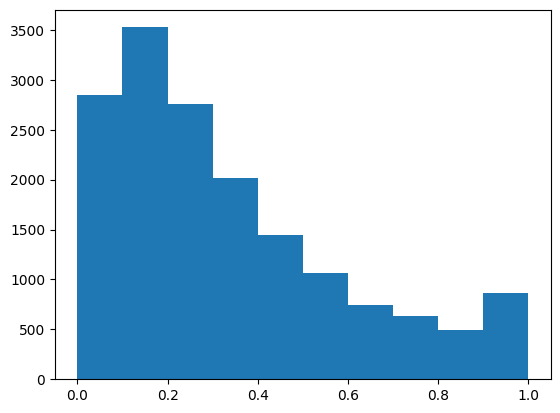

In [174]:
import matplotlib.pyplot as plt
plt.hist(highest_correlations_values_AB)
plt.show()

## save corrs

In [ ]:
import pickle

In [ ]:
with open('highest_correlations_indices_v1.pkl', 'wb') as f:
    pickle.dump(highest_correlations_indices, f)
with open('highest_correlations_values_v1.pkl', 'wb') as f:
    pickle.dump(highest_correlations_values, f)

In [ ]:
from google.colab import files
files.download('highest_correlations_indices_v1.pkl')
files.download('highest_correlations_values_v1.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !cp batch_tokens_anySamps_v1.pkl /content/drive/MyDrive/

# interpret paired features

## load tokenizer

In [ ]:
from transformers import AutoTokenizer

# Load the tokenizer for the specified model
tokenizer = AutoTokenizer.from_pretrained("roneneldan/TinyStories-1Layer-21M")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [ ]:
# Convert a single string to a token ID
single_string = "example"
token_id = tokenizer.encode(single_string, add_special_tokens=False)[0]
decoded_string = tokenizer.decode([token_id])
print(decoded_string)

example


## load dataset tokens

In [50]:
import pickle
file_path = '/content/drive/MyDrive/sae_files/batch_tokens_anySamps_v1.pkl'
with open(file_path, 'rb') as f:
    batch_tokens = pickle.load(f)

## interpret

In [51]:
%pip install jaxtyping

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [52]:
import torch
from torch import nn, Tensor
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple

In [53]:
def highest_activating_tokens(
    feature_acts,
    feature_idx: int,
    k: int = 10,  # num batch_seq samples
    batch_tokens=None
) -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    batch_size, seq_len = batch_tokens.shape

    # Get the top k largest activations for only targeted feature
    # need to flatten (batch,seq) into batch*seq first because it's ANY batch_seq, even if in same batch or same pos
    flattened_feature_acts = feature_acts[:, :, feature_idx].reshape(-1)

    top_acts_values, top_acts_indices = flattened_feature_acts.topk(k)
    # top_acts_values should be 1D
    # top_acts_indices should be also be 1D. Now, turn it back to 2D
    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return torch.stack([top_acts_batch, top_acts_seq], dim=-1), top_acts_values

In [54]:
from rich import print as rprint
def display_top_sequences(top_acts_indices, top_acts_values, batch_tokens):
    s = ""
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        # s += f'{batch_idx}\n'
        s += f'batchID: {batch_idx}, '
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq_start = max(seq_idx - 5, 0)
        seq_end = min(seq_idx + 5, batch_tokens.shape[1])
        seq = ""
        # Loop over the sequence, adding each token to the string (highlighting the token with the large activations)
        for i in range(seq_start, seq_end):
            # new_str_token = model.to_single_str_token(batch_tokens[batch_idx, i].item()).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            new_str_token = tokenizer.decode([batch_tokens[batch_idx, i].item()]).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            if i == seq_idx:
                new_str_token = f"[bold u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Print the sequence, and the activation value
        s += f'Act = {value:.2f}, Seq = "{seq}"\n'

    rprint(s)

### pair A with B

In [177]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, feature_idx_B in enumerate(highest_correlations_indices_AB[:10]):
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_A]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=batch_tokens)
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=batch_tokens)

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=batch_tokens)
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=batch_tokens)

    print('-'*50)

Correlation: 0.410124808549881
Model A Feature:  0


batchID: 99, Act = 0.74, Seq = " In the end, they both agreed that their trucks"
batchID: 99, Act = 0.64, Seq = ". In the end, they both agreed that their"
batchID: 180, Act = 0.61, Seq = " And in the end, Lily still made a beautiful"
batchID: 475, Act = 0.40, Seq = " might get punished and end up sad like Max."
batchID: 20, Act = 0.37, Seq = "\nIn the end, Tom, Sam, and"

Model B Feature:  15289


batchID: 454, Act = 0.56, Seq = " help. The man said yes and Timmy helped"
batchID: 156, Act = 0.56, Seq = " saw that it now weighed 15 pounds. The cat"
batchID: 485, Act = 0.36, Seq = " octopus said, "Yes, I have it"
batchID: 301, Act = 0.36, Seq = " going down. 3, 2, 1...\n"
batchID: 416, Act = 0.28, Seq = " day in the park.Lily liked to play"

--------------------------------------------------
Correlation: 0.4144013524055481
Model A Feature:  1


batchID: 186, Act = 1.13, Seq = " it and perform a dance with it.\n\n"
batchID: 364, Act = 0.96, Seq = " He succeeds in having fun with his ball and making"
batchID: 137, Act = 0.94, Seq = " the park and go fishing with the cheerful yellow pole"
batchID: 156, Act = 0.94, Seq = " more exercise, like playing with toys. \n"
batchID: 263, Act = 0.93, Seq = " not make jokes and tricks with presents. They do"

Model B Feature:  5945


batchID: 453, Act = 19.69, Seq = " loved going to the library with his mommy."
batchID: 103, Act = 19.55, Seq = " bookcase and read it with her parents. They"
batchID: 135, Act = 19.53, Seq = " hard or sharp, but with a little patience,"
batchID: 167, Act = 19.46, Seq = "my loved to play outside with his friends. One"
batchID: 160, Act = 19.45, Seq = " Timmy loved to play with his toy cars and"

--------------------------------------------------
Correlation: 0.2796876132488251
Model A Feature:  2


batchID: 378, Act = 2.70, Seq = " Tom and Sue were amazed by the view. They"
batchID: 69, Act = 2.54, Seq = " gazed at it, amazed by its beauty.\n"
batchID: 204, Act = 1.67, Seq = ". He was very impressed by the big house and"
batchID: 220, Act = 1.11, Seq = " rare." Lily was fascinated by the mineral and decided"
batchID: 272, Act = 0.97, Seq = ". They shared them and admired them. They did"

Model B Feature:  13187


batchID: 220, Act = 2.61, Seq = " rare." Lily was fascinated by the mineral and decided"
batchID: 75, Act = 1.67, Seq = " she couldn't stop thinking about the statue. She"
batchID: 204, Act = 1.59, Seq = ". He was very impressed by the big house and"
batchID: 378, Act = 1.53, Seq = " Tom and Sue were amazed by the view. They"
batchID: 133, Act = 1.51, Seq = ". She drew a picture of the butterfly with lots"

--------------------------------------------------
Correlation: 0.3802168071269989
Model A Feature:  3


batchID: 428, Act = 4.38, Seq = " surprise, but I think you'll like them.""
batchID: 236, Act = 1.80, Seq = " if we don't think we'll like them at"
batchID: 34, Act = 0.80, Seq = " bet you can't do tricks"
batchID: 286, Act = 0.77, Seq = " for you. We hope you are happy. We"
batchID: 376, Act = 0.70, Seq = " tail. "I think he likes us," Max"

Model B Feature:  13936


batchID: 34, Act = 2.16, Seq = " bet you can't do tricks"
batchID: 253, Act = 2.16, Seq = ", I'm going to marry"
batchID: 305, Act = 2.15, Seq = " love you."\n\nMom"
batchID: 278, Act = 2.15, Seq = " are you? Get out of"
batchID: 6, Act = 2.15, Seq = " are you sad, cow?""

--------------------------------------------------
Correlation: 0.8134111166000366
Model A Feature:  4


batchID: 315, Act = 4.51, Seq = " each other. They felt ashamed and sorry.\n"
batchID: 371, Act = 4.24, Seq = " explain. Tim felt very ashamed and scared. He"
batchID: 69, Act = 3.51, Seq = "\n\nLily felt embarrassed and didn't know"
batchID: 496, Act = 3.43, Seq = " big log! Lily felt embarrassed for making her friends"
batchID: 370, Act = 2.72, Seq = "\nBut soon he felt guilty"

Model B Feature:  14526


batchID: 391, Act = 11.67, Seq = " kids saw that Tom was embarrassed and sorry. They"
batchID: 69, Act = 11.27, Seq = "\n\nLily felt embarrassed and didn't know"
batchID: 102, Act = 11.14, Seq = " this time he wasn't embarrassed. He came up"
batchID: 496, Act = 11.08, Seq = " big log! Lily felt embarrassed for making her friends"
batchID: 101, Act = 10.98, Seq = " noticed a man who looked embarrassed. He had dropped"

--------------------------------------------------
Correlation: 0.7174808382987976
Model A Feature:  5


batchID: 99, Act = 4.89, Seq = "\n\nMax's friends laughed and teased him,"
batchID: 168, Act = 3.33, Seq = " Timmy and his friends laughed and had so much"
batchID: 64, Act = 2.55, Seq = " Sammy a joke and Sammy laughed so hard that he"
batchID: 214, Act = 2.53, Seq = " it for later. Lily laughed and continued to enjoy"
batchID: 249, Act = 2.19, Seq = " yarn and they all laughed and played together happily"

Model B Feature:  9222


batchID: 407, Act = 24.64, Seq = "\n\n"Bang, bang, bang!" Lily"
batchID: 407, Act = 22.96, Seq = ""Bang, bang, bang!" Lily says,"
batchID: 407, Act = 22.32, Seq = "\n\n"Bang, bang, bang!" Ben"
batchID: 407, Act = 20.57, Seq = ""Bang, bang, bang!" Ben says,"
batchID: 407, Act = 12.26, Seq = " toys.\n\n"Bang, bang, bang"

--------------------------------------------------
Correlation: 0.09838986396789551
Model A Feature:  6


batchID: 319, Act = 5.03, Seq = ". They have many colors and they make marks on"
batchID: 323, Act = 4.96, Seq = ". She had many colors and brushes. She painted"
batchID: 338, Act = 4.83, Seq = ". There were many colors and flavors.\n\n"
batchID: 264, Act = 4.45, Seq = ". She liked the colors and the shapes. She"
batchID: 322, Act = 4.12, Seq = " We can make many colors and shapes. We can"

Model B Feature:  15831


batchID: 380, Act = 5.01, Seq = " happy you're both safe and sound. But you"
batchID: 380, Act = 4.67, Seq = ". She hugged them both and said, "I"
batchID: 84, Act = 4.49, Seq = " \n\nLily and her mommy went"
batchID: 237, Act = 4.40, Seq = "." But Lily kept listening and realized it was the"
batchID: 19, Act = 4.31, Seq = " give up. But Tom and Sam were brave."

--------------------------------------------------
Correlation: 0.17142759263515472
Model A Feature:  7


batchID: 428, Act = 1.37, Seq = " big hug and said, "I'll come back"
batchID: 125, Act = 1.31, Seq = " was time to go. She said goodbye to the"
batchID: 428, Act = 1.17, Seq = "'s grandma to leave. She gave Lily a big"
batchID: 199, Act = 1.06, Seq = " go home. Timmy went to bed that night"
batchID: 111, Act = 1.04, Seq = " back and play again tomorrow. From that day on"

Model B Feature:  5850


batchID: 125, Act = 0.57, Seq = " knew it was time to go. She said goodbye"
batchID: 212, Act = 0.51, Seq = " His mom said they would go back to the park"
batchID: 170, Act = 0.46, Seq = " sad because she wanted to go to the park so"
batchID: 1, Act = 0.38, Seq = " about the icy hill and how she couldn't climb"
batchID: 137, Act = 0.28, Seq = " together in the park and go fishing with the cheerful"

--------------------------------------------------
Correlation: 0.24444030225276947
Model A Feature:  8


batchID: 113, Act = 3.17, Seq = "\n\n"Wow, Lily! Your painting is"
batchID: 450, Act = 2.00, Seq = "\n\n"Hello, Lily," said her neighbor"
batchID: 296, Act = 1.79, Seq = "\n\n"Wow, Lily! You have a"
batchID: 112, Act = 1.76, Seq = "\n"Hi, Finny! Do you want"
batchID: 112, Act = 1.67, Seq = "\n\n"Hi, Finny! Do you"

Model B Feature:  6640


batchID: 112, Act = 0.55, Seq = "\n"Hi, Finny! Do you want"
batchID: 112, Act = 0.53, Seq = " a little fish named Finny.\n\n""
batchID: 0, Act = 0.00, Seq = "Spot. Spot saw the shiny car"
batchID: 0, Act = 0.00, Seq = "Spot. Spot saw the shiny"
batchID: 0, Act = 0.00, Seq = "Spot. Spot saw the"

--------------------------------------------------
Correlation: 0.6159129738807678
Model A Feature:  9


batchID: 262, Act = 7.19, Seq = " that they have to say sorry. They tell them"
batchID: 406, Act = 6.13, Seq = " to clean up and say sorry to each other.""
batchID: 371, Act = 4.93, Seq = ". He wanted to say sorry to Lily and give"
batchID: 71, Act = 4.79, Seq = " your friends when they say sorry too. They played"
batchID: 71, Act = 4.73, Seq = " it's important to say sorry when you make a"

Model B Feature:  7281


batchID: 434, Act = 14.05, Seq = " to Max, "I regret that we have to"
batchID: 371, Act = 9.97, Seq = " taken the toy. He regretted his actions"
batchID: 322, Act = 7.46, Seq = ", Ben. I am sorry too. I do"
batchID: 279, Act = 7.40, Seq = " also told him he was sorry for the cat who"
batchID: 397, Act = 7.39, Seq = ""Anna, I am sorry," Ben says."

--------------------------------------------------


# search modB features with keyword, get modA f pair

## fns

In [ ]:
def find_indices_with_keyword(fList, keyword):
    """
    Find all indices of fList which contain the keyword in the string at those indices.

    Args:
    fList (list of str): List of strings to search within.
    keyword (str): Keyword to search for within the strings of fList.

    Returns:
    list of int: List of indices where the keyword is found within the strings of fList.
    """
    index_list = []
    for index, string in enumerate(fList):
        split_list = string.split(',')
        no_space_list = [i.replace(' ', '').lower() for i in split_list]
        if keyword in no_space_list:
            index_list.append(index)
    return index_list

In [ ]:
def get_values_from_indices(indices, values_list):
    """
    Get the values from values_list at the specified indices.

    Args:
    indices (list of int): List of indices to retrieve values from.
    values_list (list): List of values from which to retrieve the specified indices.

    Returns:
    list: List of values from values_list at the specified indices.
    """
    return [values_list[index] for index in indices]

## test

In [ ]:
keyword = "king"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
print(modA_feats)
print(modB_feats)

[11920, 11222]
[5430, 10868]


In [ ]:
print(fList_model_A[11920])
print(fList_model_B[5430])

 monster,  monster,  princess,  princess,  knight, 
 princess,  princess,  princess,  princess,  king, 


In [ ]:
keyword = "spot"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
print(modA_feats)
print(modB_feats)

[0, 12104, 0, 0, 0, 0, 2548, 0, 0, 14534, 9409, 0, 9282, 15926, 14668, 8930, 2925, 0, 0, 0, 4364, 7302, 13046, 13595, 0, 0, 0, 15246, 0, 0, 11313, 0, 2567, 0, 0, 0, 5510, 14787, 14126, 0, 0, 0, 13071, 14169, 0, 12638, 0, 0, 0, 748, 0, 0, 0, 0, 2101, 0, 0, 11735, 0, 0, 0, 663, 0, 6748, 0, 0, 0, 0, 15533, 0, 0, 0, 1164, 0, 0, 5477, 1518, 0, 13910, 10664, 0, 2425, 3258, 4589, 0, 15947, 9928, 0, 0, 3216, 13453, 12281, 5835, 11528, 0, 0, 12211, 0, 6665, 13776, 0, 0, 10761, 8671, 0, 8972, 15063, 0, 0, 11133, 14588, 8096, 0, 0, 0, 382, 216, 0, 224, 0, 0, 5376, 7223, 0, 0, 0, 2197, 4835, 4018, 633, 0, 10867, 0, 4770, 0, 0, 0, 0, 0, 0, 6808, 0, 9834, 1689, 0, 14732, 0, 6607, 0, 10594, 0, 12477, 518, 0, 11228, 0, 0, 6249, 836, 9929, 675, 0, 0, 0, 0, 0, 11630, 11528, 7625, 0, 12168, 0, 11040, 0, 0, 0, 0, 10060, 8439, 4130, 8149, 0, 0, 0, 0, 11234, 0, 0, 0, 0, 13720, 0, 135, 7390, 0, 0, 0, 0, 10553, 0, 0, 10789, 0, 0, 13797, 0, 0, 0, 0, 0, 0, 0, 8752, 15246, 4707, 13953, 7563, 0, 0, 0, 0, 0, 0, 16

In [ ]:
print(fList_model_A[0])
print(fList_model_B[12])

 both,  they,  Lily,  up,  Tom, 
., Spot,  Spot,  the,  saw, 


# jaccard on feature subset

## fns

In [36]:
import functools
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import numpy.typing as npt
import torch


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(
    R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad"
) -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def sim_random_baseline(
    rep1: torch.Tensor, rep2: torch.Tensor, sim_func: Callable, n_permutations: int = 10
) -> Dict[str, Any]:
    torch.manual_seed(1234)
    scores = []
    for _ in range(n_permutations):
        perm = torch.randperm(rep1.size(0))

        score = sim_func(rep1[perm, :], rep2)
        score = score if isinstance(score, float) else score["score"]

        scores.append(score)

    return {"baseline_scores": np.array(scores)}


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray], Dict[str, Any]],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray) -> Dict[str, Any]:
        for preprocess_func in self.preprocess_funcs:
            R = preprocess_func(R)
            Rp = preprocess_func(Rp)
        return self.similarity_func(R, Rp)

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return (
                func.__name__
                if not isinstance(func, functools.partial)
                else func.func.__name__
            )

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )

In [37]:
from typing import List, Set, Union

import numpy as np
import numpy.typing as npt
import sklearn.neighbors
import torch

# from llmcomp.measures.utils import to_numpy_if_needed


def _jac_sim_i(idx_R: Set[int], idx_Rp: Set[int]) -> float:
    return len(idx_R.intersection(idx_Rp)) / len(idx_R.union(idx_Rp))


def jaccard_similarity(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    k: int = 10,
    inner: str = "cosine",
    n_jobs: int = 8,
) -> float:
    R, Rp = to_numpy_if_needed(R, Rp)

    indices_R = nn_array_to_setlist(top_k_neighbors(R, k, inner, n_jobs))
    indices_Rp = nn_array_to_setlist(top_k_neighbors(Rp, k, inner, n_jobs))

    return float(
        np.mean(
            [_jac_sim_i(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
        )
    )


def top_k_neighbors(
    R: npt.NDArray,
    k: int,
    inner: str,
    n_jobs: int,
) -> npt.NDArray:
    # k+1 nearest neighbors, because we pass in all the data, which means that a point
    # will be the nearest neighbor to itself. We remove this point from the results and
    # report only the k nearest neighbors distinct from the point itself.
    nns = sklearn.neighbors.NearestNeighbors(
        n_neighbors=k + 1, metric=inner, n_jobs=n_jobs
    )
    nns.fit(R)
    _, nns = nns.kneighbors(R)
    return nns[:, 1:]


def nn_array_to_setlist(nn: npt.NDArray) -> List[Set[int]]:
    return [set(idx) for idx in nn]

## entire space

slow

In [40]:
weight_matrix_np.shape

(16384, 1024)

In [41]:
weight_matrix_2.shape

(32768, 768)

In [74]:
len(highest_correlations_indices)

16384

In [44]:
len(list(set(highest_correlations_indices)))

1688

In [38]:
jaccard_similarity(weight_matrix_np, weight_matrix_2)

0.00015740645559210524

In [75]:
jaccard_similarity(weight_matrix_np[highest_correlations_indices, :], weight_matrix_2[:16384, :])

0.002852915897375946

## pair A with B

In [76]:
len(list(set(highest_correlations_indices_AB)))

2405

In [169]:
jaccard_similarity(weight_matrix_np, weight_matrix_2[highest_correlations_indices_AB])

0.04997308974321018

## 1-1 only

In [155]:
# highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals

uniq_corr_indices_AB_forB = []
uniq_corr_indices_AB_forA = []
for ind_A, ind_B in enumerate(highest_correlations_indices_AB):
    if ind_B not in uniq_corr_indices_AB_forB:
        uniq_corr_indices_AB_forA.append(ind_A)
        uniq_corr_indices_AB_forB.append(ind_B)

In [156]:
len(uniq_corr_indices_AB_forA)

2405

In [159]:
# unpaired
jaccard_similarity(weight_matrix_np[:2405], weight_matrix_2[:2405])

0.001969580916949338

In [158]:
jaccard_similarity(weight_matrix_np[uniq_corr_indices_AB_forA], weight_matrix_2[uniq_corr_indices_AB_forB])

0.010207993180129401

In [161]:
all_rand_scores = []
num_feats = len(uniq_corr_indices_AB_forA)
for i in range(10):
    rand_modA_feats = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=num_feats).tolist()
    rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=num_feats).tolist()

    score = jaccard_similarity(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats])
    all_rand_scores.append(score)
sum(all_rand_scores) / len(all_rand_scores)

0.002284227547385442

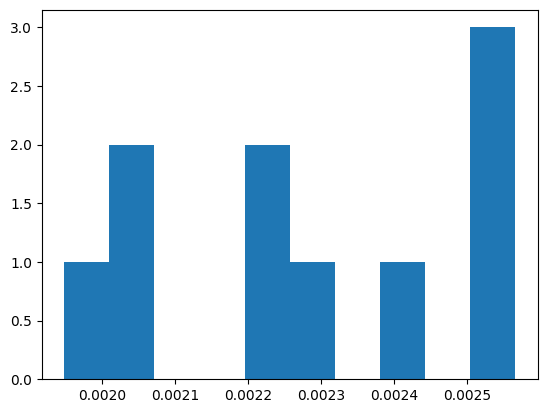

In [162]:
plt.hist(all_rand_scores)
plt.show()

## remove all corr feats less than 0.5

In [103]:
new_highest_correlations_indices_AB_A = []
new_highest_correlations_indices_AB = []
new_highest_correlations_values_AB = []

ind_A = 0
for ind_B, val in zip(highest_correlations_indices_AB, highest_correlations_values_AB):
    if val > 0.5:
        new_highest_correlations_indices_AB_A.append(ind_A)
        new_highest_correlations_indices_AB.append(ind_B)
        new_highest_correlations_values_AB.append(val)
    ind_A += 1

In [66]:
len(new_highest_correlations_values_AB)

4165

In [78]:
len(list(set(new_highest_correlations_indices_AB_A)))

4165

In [77]:
len(list(set(new_highest_correlations_indices_AB)))

1642

In [72]:
weight_matrix_np[new_highest_correlations_indices_AB_A, :].shape

(4165, 1024)

In [104]:
# unpaired
jaccard_similarity(weight_matrix_np[:len(new_highest_correlations_indices_AB_A), :], weight_matrix_2[:len(new_highest_correlations_indices_AB_A), :])

0.0012004801920768306

In [73]:
jaccard_similarity(weight_matrix_np[new_highest_correlations_indices_AB_A, :], weight_matrix_2[new_highest_correlations_indices_AB, :])

0.10661393445002243

## remove all corr feats less than 0.7

In [105]:
new_highest_correlations_indices_AB_A = []
new_highest_correlations_indices_AB = []
new_highest_correlations_values_AB = []

ind_A = 0
for ind_B, val in zip(highest_correlations_indices_AB, highest_correlations_values_AB):
    if val > 0.7:
        new_highest_correlations_indices_AB_A.append(ind_A)
        new_highest_correlations_indices_AB.append(ind_B)
        new_highest_correlations_values_AB.append(val)
    ind_A += 1

In [96]:
len(new_highest_correlations_values_AB)

2168

In [97]:
len(list(set(new_highest_correlations_indices_AB_A)))

2168

In [98]:
len(list(set(new_highest_correlations_indices_AB)))

1113

In [99]:
weight_matrix_np[new_highest_correlations_indices_AB_A, :].shape

(2168, 1024)

In [107]:
# unpaired
jaccard_similarity(weight_matrix_np[:len(new_highest_correlations_indices_AB_A), :], weight_matrix_2[:len(new_highest_correlations_indices_AB_A), :], k =10)

0.0022361407824604564

In [100]:
jaccard_similarity(weight_matrix_np[new_highest_correlations_indices_AB_A, :], weight_matrix_2[new_highest_correlations_indices_AB, :], k=10)

0.08726149598056478

In [106]:
# unpaired
jaccard_similarity(weight_matrix_np[:len(new_highest_correlations_indices_AB_A), :], weight_matrix_2[:len(new_highest_correlations_indices_AB_A), :], k =4)

0.0011201897733263046

In [101]:
jaccard_similarity(weight_matrix_np[new_highest_correlations_indices_AB_A, :], weight_matrix_2[new_highest_correlations_indices_AB, :], k=4)

0.12322966086803722

## remove all corr feats less than 0.9

In [115]:
new_highest_correlations_indices_AB_A = []
new_highest_correlations_indices_AB = []
new_highest_correlations_values_AB = []

ind_A = 0
for ind_B, val in zip(highest_correlations_indices_AB, highest_correlations_values_AB):
    if val > 0.9:
        new_highest_correlations_indices_AB_A.append(ind_A)
        new_highest_correlations_indices_AB.append(ind_B)
        new_highest_correlations_values_AB.append(val)
    ind_A += 1

In [86]:
len(new_highest_correlations_values_AB)

1076

In [87]:
len(list(set(new_highest_correlations_indices_AB_A)))

1076

In [88]:
len(list(set(new_highest_correlations_indices_AB)))

664

In [89]:
weight_matrix_np[new_highest_correlations_indices_AB_A, :].shape

(1076, 1024)

In [111]:
# unpaired
jaccard_similarity(weight_matrix_np[:len(new_highest_correlations_indices_AB_A), :], weight_matrix_2[:len(new_highest_correlations_indices_AB_A), :], k =10)

0.004119654775103806

In [94]:
jaccard_similarity(weight_matrix_np[new_highest_correlations_indices_AB_A, :], weight_matrix_2[new_highest_correlations_indices_AB, :], k=10)

0.0633733458666993

In [110]:
# unpaired
jaccard_similarity(weight_matrix_np[:len(new_highest_correlations_indices_AB_A), :], weight_matrix_2[:len(new_highest_correlations_indices_AB_A), :], k =4)

0.0023898035050451405

In [91]:
jaccard_similarity(weight_matrix_np[new_highest_correlations_indices_AB_A, :], weight_matrix_2[new_highest_correlations_indices_AB, :], k=4)

0.10130111524163568

# single token subspaces

In [113]:
def get_rand_scores(modA_feats, modB_feats, k: int = 10):
    total_scores = 0
    for i in range(10):
        # if i % 20 == 0:
        #     print(i)
        rand_modA_feats = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=len(modA_feats)).tolist()
        rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=len(modB_feats)).tolist()
        X_subset = weight_matrix_np[rand_modA_feats, :]
        Y_subset = weight_matrix_2[rand_modB_feats, :]

        total_scores += jaccard_similarity(X_subset, Y_subset, k)

    return total_scores / 10

In [ ]:
keyword = "upon"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

In [ ]:
keyword = "once"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

45
0.33185336812787786
0.13582638744506648


In [ ]:
keyword = "she"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(modA_feats, modB_feats))

380
0.21164830837512932
0.013231430938026183


In [ ]:
keyword = "let"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(jaccard_similarity(X_subset, Y_subset, k=4))
print(get_rand_scores(modA_feats, modB_feats, k=4))

43
0.21173864894795127
0.059636766334440754


## corr explora

In [ ]:
modA_feats[:3]

[1309, 16063, 13316]

In [ ]:
weight_matrix_np[modA_feats[:3], :]

array([[ 0.02785099, -0.02477001,  0.00858831, ...,  0.015927  ,
        -0.06672496,  0.02420243],
       [ 0.01022755, -0.00850311,  0.01139022, ..., -0.00653903,
         0.00299397,  0.01589398],
       [-0.00160716, -0.00215119,  0.00527383, ..., -0.00272901,
         0.00032616, -0.0038715 ]], dtype=float32)

In [ ]:
weight_matrix_np[13316, :]

array([-0.00160716, -0.00215119,  0.00527383, ..., -0.00272901,
        0.00032616, -0.0038715 ], dtype=float32)

In [ ]:
weight_matrix_np[[1,1,2], :]

array([[-1.0435611e-02, -1.9478016e-02, -8.0988961e-05, ...,
        -1.6303809e-02, -2.4349693e-02, -3.5294676e-03],
       [-1.0435611e-02, -1.9478016e-02, -8.0988961e-05, ...,
        -1.6303809e-02, -2.4349693e-02, -3.5294676e-03],
       [ 3.0684073e-02, -2.5800992e-02, -7.9628965e-03, ...,
         1.7961942e-02,  2.7222697e-02, -1.2481678e-02]], dtype=float32)

In [ ]:
keyword_1 = "once"
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(list(set(modA_feats))))
len(list(set(modB_feats)))

22


45

In [ ]:
keyword_1 = "she"
modB_feats = find_indices_with_keyword(fList_model_B, keyword_1)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(list(set(modA_feats))))
len(list(set(modB_feats)))

247


380

In [ ]:
# Generate 50 unique indices
unique_feats_A = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=50).tolist()

# Create a list with repeats by duplicating the unique elements
rand_modA_feats = unique_feats_A + unique_feats_A

# Shuffle the list to mix unique and repeated elements
np.random.shuffle(rand_modA_feats)

# Ensure rand_modB_feats remains fully random
rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=100).tolist()

# Subset the weight matrices using the selected features
X_subset = weight_matrix_np[rand_modA_feats, :]
Y_subset = weight_matrix_2[rand_modB_feats, :]

# Update total_scores with the Jaccard similarity between the subsets
jaccard_similarity(X_subset, Y_subset)

0.05861283109735121

In [ ]:
# Generate 50 unique indices
unique_feats_A = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=10).tolist()

# Create a list with repeats by duplicating the unique elements
rand_modA_feats = unique_feats_A + unique_feats_A

# Shuffle the list to mix unique and repeated elements
np.random.shuffle(rand_modA_feats)

# Ensure rand_modB_feats remains fully random
rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=20).tolist()

# Subset the weight matrices using the selected features
X_subset = weight_matrix_np[rand_modA_feats, :]
Y_subset = weight_matrix_2[rand_modB_feats, :]

# Update total_scores with the Jaccard similarity between the subsets
jaccard_similarity(X_subset, Y_subset, k=3)

0.06499999999999999

## see what feat neighs they have in common

In [ ]:
kw_dict = {}
for i, kw in enumerate(["girl", "boy", "she", "he", "her", "his", "it", "once", "upon", "a", "time"]):
    kw_dict[i] = kw

In [ ]:
indices_R = nn_array_to_setlist(top_k_neighbors(X_subset, 4, "cosine", 8))
replaced_sets_list = [{kw_dict.get(ind, ind) for ind in s} for s in indices_R]
for i, kw_neighs in enumerate(replaced_sets_list):
    print(kw_dict[i], ': ', kw_neighs)

girl :  {'he', 'her', 'once', 'boy'}
boy :  {'her', 'once', 'he', 'she'}
she :  {'he', 'her', 'once', 'boy'}
he :  {'her', 'once', 'boy', 'she'}
her :  {'he', 'once', 'boy', 'his'}
his :  {'he', 'her', 'once', 'boy'}
it :  {'he', 'her', 'once', 'boy'}
once :  {'he', 'her', 'boy', 'she'}
upon :  {'he', 'once', 'boy', 'she'}
a :  {'he', 'her', 'once', 'boy'}
time :  {'he', 'once', 'boy', 'she'}


In [ ]:
indices_Rp = nn_array_to_setlist(top_k_neighbors(Y_subset, 4, "cosine", 8))
replaced_sets_list_2 = [{kw_dict.get(ind, ind) for ind in s} for s in indices_Rp]
for i, kw_neighs in enumerate(replaced_sets_list_2):
    print(kw_dict[i], ': ', kw_neighs)

girl :  {'upon', 'once', 'boy', 'she'}
boy :  {'upon', 'once', 'he', 'she'}
she :  {'he', 'upon', 'once', 'boy'}
he :  {'upon', 'once', 'boy', 'she'}
her :  {'once', 'he', 'his', 'she'}
his :  {'her', 'upon', 'girl', 'she'}
it :  {'he', 'once', 'boy', 'she'}
once :  {'he', 'upon', 'boy', 'she'}
upon :  {'once', 'boy', 'girl', 'she'}
a :  {'upon', 'once', 'boy', 'she'}
time :  {'upon', 'his', 'girl', 'she'}


In [ ]:
R_Rp = [set.intersection(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
replaced_sets_list_both = [{kw_dict.get(ind, ind) for ind in s} for s in R_Rp]
for i, kw_neighs in enumerate(replaced_sets_list_both):
    print(kw_dict[i], ': ', kw_neighs)

girl :  {'once', 'boy'}
boy :  {'once', 'he', 'she'}
she :  {'he', 'once', 'boy'}
he :  {'once', 'boy', 'she'}
her :  {'once', 'he', 'his'}
his :  {'her'}
it :  {'he', 'once', 'boy'}
once :  {'he', 'boy', 'she'}
upon :  {'once', 'boy', 'she'}
a :  {'once', 'boy'}
time :  {'she'}


In [ ]:
[_jac_sim_i(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]

[0.3333333333333333,
 0.6,
 0.6,
 0.6,
 0.6,
 0.14285714285714285,
 0.6,
 0.6,
 0.6,
 0.3333333333333333,
 0.14285714285714285,
 0.6]

In [ ]:
rand_modA_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=len(mixed_modA_feats)).tolist()
rand_X_subset = weight_matrix_np[rand_modA_feats, :]
indices_R = nn_array_to_setlist(top_k_neighbors(rand_X_subset, 4, "cosine", 8))
indices_R

[{3, 7, 8, 11},
 {5, 8, 10, 11},
 {0, 1, 5, 10},
 {5, 7, 8, 11},
 {1, 6, 7, 9},
 {7, 8, 10, 11},
 {4, 5, 7, 9},
 {3, 5, 8, 11},
 {5, 7, 10, 11},
 {3, 5, 6, 7},
 {5, 7, 8, 11},
 {5, 7, 8, 10}]

### another

In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []

keywords = ["girl", "boy", "she", "he", "her", "his", "it"]

for kw in keywords:
    print(kw + ": ")
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
    mixed_modA_feats.append(modA_feats[0])
    mixed_modB_feats.append(modB_feats[0])
    print(len(modB_feats), len(list(set(modA_feats))))

X_subset = weight_matrix_np[mixed_modA_feats, :]
Y_subset = weight_matrix_2[mixed_modB_feats, :]
print(len(mixed_modA_feats))
print(jaccard_similarity(X_subset, Y_subset, k=2))

# print(get_rand_scores(mixed_modA_feats, mixed_modB_feats, k=2))

girl: 
38 32
boy: 
43 38
she: 
380 247
he: 
366 234
her: 
216 173
his: 
186 151
it: 
272 199
7
0.7142857142857143


In [ ]:
kw_dict = {}
for i, kw in enumerate(keywords):
    kw_dict[i] = kw

In [ ]:
indices_R = nn_array_to_setlist(top_k_neighbors(X_subset, 2, "cosine", 8))
replaced_sets_list = [{kw_dict.get(ind, ind) for ind in s} for s in indices_R]
for i, kw_neighs in enumerate(replaced_sets_list):
    print(kw_dict[i], ': ', kw_neighs)

girl :  {'her', 'boy'}
boy :  {'he', 'she'}
she :  {'he', 'boy'}
he :  {'boy', 'she'}
her :  {'boy', 'his'}
his :  {'her', 'boy'}
it :  {'he', 'boy'}


In [ ]:
indices_Rp = nn_array_to_setlist(top_k_neighbors(Y_subset, 2, "cosine", 8))
replaced_sets_list_2 = [{kw_dict.get(ind, ind) for ind in s} for s in indices_Rp]
for i, kw_neighs in enumerate(replaced_sets_list_2):
    print(kw_dict[i], ': ', kw_neighs)

girl :  {'boy', 'she'}
boy :  {'he', 'she'}
she :  {'he', 'boy'}
he :  {'boy', 'she'}
her :  {'his', 'she'}
his :  {'her', 'she'}
it :  {'he', 'boy'}


In [ ]:
R_Rp = [set.intersection(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
replaced_sets_list_both = [{kw_dict.get(ind, ind) for ind in s} for s in R_Rp]
for i, kw_neighs in enumerate(replaced_sets_list_both):
    print(kw_dict[i], ': ', kw_neighs)

girl :  {'boy'}
boy :  {'he', 'she'}
she :  {'he', 'boy'}
he :  {'boy', 'she'}
her :  {'his'}
his :  {'her'}
it :  {'he', 'boy'}


## only take NN of 1-1 features

get rid of features in B that map to features in A that were already mapped to

In [ ]:
keyword = "she"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)

new_modB_feats = []
new_modA_feats = []
for ind_B, ind_A in zip(modB_feats, modA_feats):
    if ind_A not in new_modA_feats:
        new_modA_feats.append(ind_A)
        new_modB_feats.append(ind_B)

print(len(new_modA_feats), len(list(set(new_modA_feats))))
print(len(new_modB_feats), len(list(set(new_modB_feats))))

247 247
247 247


In [ ]:
X_subset = weight_matrix_np[new_modA_feats, :]
Y_subset = weight_matrix_2[new_modB_feats, :]

print(jaccard_similarity(X_subset, Y_subset))
print(get_rand_scores(new_modA_feats, new_modB_feats))

0.22459661916738163
0.02207425117926991


# jaccard on token actvs

## test

In [180]:
reshaped_activations_A.shape

torch.Size([20000, 16384])

In [179]:
reshaped_activations_B.shape

torch.Size([20000, 16384])

In [178]:
jaccard_similarity(reshaped_activations_A, reshaped_activations_B)

0.12619193868566933

In [184]:
jaccard_similarity(reshaped_activations_A, reshaped_activations_B[:, highest_correlations_indices_AB])

0.14626150757567166

In [ ]:
import random
row_idxs = list(range(reshaped_activations_A.shape[0]))
random.shuffle(row_idxs)
jaccard_similarity(reshaped_activations_A[row_idxs, :], reshaped_activations_B)

## by corr features

In [181]:
reshaped_activations_A.t().shape

torch.Size([16384, 20000])

In [183]:
#unpaired
jaccard_similarity(reshaped_activations_A.t(), reshaped_activations_B.t())

0.06103271922290024

In [182]:
jaccard_similarity(reshaped_activations_A.t(), reshaped_activations_B.t()[highest_correlations_indices_AB])

0.11389674056179097

# perm procr

## fn

In [117]:
import functools
import logging
from abc import ABC
from abc import abstractmethod
from dataclasses import dataclass
from dataclasses import field
from typing import Any
from typing import Callable
from typing import get_args
from typing import List
from typing import Literal
from typing import Optional
from typing import Protocol
from typing import Tuple
from typing import Union

import numpy as np
import numpy.typing as npt
import torch
from einops import rearrange
# from loguru import logger

log = logging.getLogger(__name__)


SHAPE_TYPE = Literal["nd", "ntd", "nchw"]

ND_SHAPE, NTD_SHAPE, NCHW_SHAPE = get_args(SHAPE_TYPE)[0], get_args(SHAPE_TYPE)[1], get_args(SHAPE_TYPE)[2]


class SimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float: ...


class RSMSimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE, n_jobs: int
    ) -> float: ...


@dataclass
class BaseSimilarityMeasure(ABC):
    larger_is_more_similar: bool
    is_symmetric: bool

    is_metric: bool | None = None
    invariant_to_affine: bool | None = None
    invariant_to_invertible_linear: bool | None = None
    invariant_to_ortho: bool | None = None
    invariant_to_permutation: bool | None = None
    invariant_to_isotropic_scaling: bool | None = None
    invariant_to_translation: bool | None = None
    name: str = field(init=False)

    def __post_init__(self):
        self.name = self.__class__.__name__

    @abstractmethod
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        raise NotImplementedError


class FunctionalSimilarityMeasure(BaseSimilarityMeasure):
    @abstractmethod
    def __call__(self, output_a: torch.Tensor | npt.NDArray, output_b: torch.Tensor | npt.NDArray) -> float:
        raise NotImplementedError


@dataclass(kw_only=True)
class RepresentationalSimilarityMeasure(BaseSimilarityMeasure):
    sim_func: SimilarityFunction

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float:
        return self.sim_func(R, Rp, shape)


class RSMSimilarityMeasure(RepresentationalSimilarityMeasure):
    sim_func: RSMSimilarityFunction

    @staticmethod
    def estimate_good_number_of_jobs(R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray) -> int:
        # RSMs in are NxN (or DxD) so the number of jobs should roughly scale quadratically with increase in N (or D).
        # False! As long as sklearn-native metrics are used, they will use parallel implementations regardless of job
        # count. Each job would spawn their own threads, which leads to oversubscription of cores and thus slowdown.
        # This seems to be not fully correct (n_jobs=2 seems to actually use two cores), but using n_jobs=1 seems the
        # fastest.
        return 1

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
        n_jobs: Optional[int] = None,
    ) -> float:
        if n_jobs is None:
            n_jobs = self.estimate_good_number_of_jobs(R, Rp)
        return self.sim_func(R, Rp, shape, n_jobs=n_jobs)


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad") -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def normalize_row_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord=2, axis=1, keepdims=True)


def standardize(R: npt.NDArray) -> npt.NDArray:
    return (R - R.mean(axis=0, keepdims=True)) / R.std(axis=0)


def double_center(x: npt.NDArray) -> npt.NDArray:
    return x - x.mean(axis=0, keepdims=True) - x.mean(axis=1, keepdims=True) + x.mean()


def align_spatial_dimensions(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Aligns spatial representations by resizing them to the smallest spatial dimension.
    Subsequent aligned spatial representations are flattened, with the spatial aligned representations
    moving into the *sample* dimension.
    """
    R_re, Rp_re = resize_wh_reps(R, Rp)
    R_re = rearrange(R_re, "n c h w -> (n h w) c")
    Rp_re = rearrange(Rp_re, "n c h w -> (n h w) c")
    if R_re.shape[0] > 5000:
        logger.info(f"Got {R_re.shape[0]} samples in N after flattening. Subsampling to reduce compute.")
        subsample = R_re.shape[0] // 5000
        R_re = R_re[::subsample]
        Rp_re = Rp_re[::subsample]

    return R_re, Rp_re


def average_pool_downsample(R, resize: bool, new_size: tuple[int, int]):
    if not resize:
        return R  # do nothing
    else:
        is_numpy = isinstance(R, np.ndarray)
        R_torch = torch.from_numpy(R) if is_numpy else R
        R_torch = torch.nn.functional.adaptive_avg_pool2d(R_torch, new_size)
        return R_torch.numpy() if is_numpy else R_torch


def resize_wh_reps(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Function for resizing spatial representations that are not the same size.
    Does through fourier transform and resizing.

    Args:
        R: numpy array of shape  [batch_size, height, width, num_channels]
        RP: numpy array of shape [batch_size, height, width, num_channels]

    Returns:
        fft_acts1: numpy array of shape [batch_size, (new) height, (new) width, num_channels]
        fft_acts2: numpy array of shape [batch_size, (new) height, (new) width, num_channels]

    """
    height1, width1 = R.shape[2], R.shape[3]
    height2, width2 = Rp.shape[2], Rp.shape[3]
    if height1 != height2 or width1 != width2:
        height = min(height1, height2)
        width = min(width1, width2)
        new_size = [height, width]
        resize = True
    else:
        height = height1
        width = width1
        new_size = None
        resize = False

    # resize and preprocess with fft
    avg_ds1 = average_pool_downsample(R, resize=resize, new_size=new_size)
    avg_ds2 = average_pool_downsample(Rp, resize=resize, new_size=new_size)
    return avg_ds1, avg_ds2


def fft_resize(images, resize=False, new_size=None):
    """Function for applying DFT and resizing.

    This function takes in an array of images, applies the 2-d fourier transform
    and resizes them according to new_size, keeping the frequencies that overlap
    between the two sizes.

    Args:
              images: a numpy array with shape
                      [batch_size, height, width, num_channels]
              resize: boolean, whether or not to resize
              new_size: a tuple (size, size), with height and width the same

    Returns:
              im_fft_downsampled: a numpy array with shape
                           [batch_size, (new) height, (new) width, num_channels]
    """
    assert len(images.shape) == 4, "expecting images to be" "[batch_size, height, width, num_channels]"
    if resize:
        # FFT --> remove high frequencies --> inverse FFT
        im_complex = images.astype("complex64")
        im_fft = np.fft.fft2(im_complex, axes=(1, 2))
        im_shifted = np.fft.fftshift(im_fft, axes=(1, 2))

        center_width = im_shifted.shape[2] // 2
        center_height = im_shifted.shape[1] // 2
        half_w = new_size[0] // 2
        half_h = new_size[1] // 2
        cropped_fft = im_shifted[
            :, center_height - half_h : center_height + half_h, center_width - half_w : center_width + half_w, :
        ]
        cropped_fft_shifted_back = np.fft.ifft2(cropped_fft, axes=(1, 2))
        return cropped_fft_shifted_back.real
    else:
        return images


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray, SHAPE_TYPE], float],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray, shape: SHAPE_TYPE) -> float:
        try:
            for preprocess_func in self.preprocess_funcs:
                R = preprocess_func(R)
                Rp = preprocess_func(Rp)
            return self.similarity_func(R, Rp, shape)
        except ValueError as e:
            log.info(f"Pipeline failed: {e}")
            return np.nan

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return func.__name__ if not isinstance(func, functools.partial) else func.func.__name__

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )


def flatten(*args: Union[torch.Tensor, npt.NDArray], shape: SHAPE_TYPE) -> List[Union[torch.Tensor, npt.NDArray]]:
    if shape == "ntd":
        return list(map(flatten_nxtxd_to_ntxd, args))
    elif shape == "nd":
        return list(args)
    elif shape == "nchw":
        return list(map(flatten_nxcxhxw_to_nxchw, args))  # Flattening non-trivial for nchw
    else:
        raise ValueError("Unknown shape of representations. Must be one of 'ntd', 'nchw', 'nd'.")


def flatten_nxtxd_to_ntxd(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.flatten(R, start_dim=0, end_dim=1)
    log.debug("Shape after flattening: %s", str(R.shape))
    return R


def flatten_nxcxhxw_to_nxchw(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.reshape(R, (R.shape[0], -1))
    log.debug("Shape after flattening: %s", str(R.shape))
    return R

In [118]:
import scipy.optimize

def permutation_procrustes(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    optimal_permutation_alignment: Optional[Tuple[npt.NDArray, npt.NDArray]] = None,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    R, Rp = adjust_dimensionality(R, Rp)

    if not optimal_permutation_alignment:
        PR, PRp = scipy.optimize.linear_sum_assignment(R.T @ Rp, maximize=True)  # returns column assignments
        optimal_permutation_alignment = (PR, PRp)
    PR, PRp = optimal_permutation_alignment
    return float(np.linalg.norm(R[:, PR] - Rp[:, PRp], ord="fro"))

## all decoder weights

In [ ]:
permutation_procrustes(weight_matrix_np, weight_matrix_2, "nd")

133.03709411621094

In [ ]:
permutation_procrustes(weight_matrix_np[highest_correlations_indices_v1], weight_matrix_2, "nd")

128.85845947265625

# RSA

## fns

In [119]:
from typing import Optional
from typing import Union

import numpy as np
import numpy.typing as npt
import scipy.spatial.distance
import scipy.stats
import sklearn.metrics
import torch
# from repsim.measures.utils import flatten
# from repsim.measures.utils import RSMSimilarityMeasure
# from repsim.measures.utils import SHAPE_TYPE
# from repsim.measures.utils import to_numpy_if_needed


def representational_similarity_analysis(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    inner="correlation",
    outer="spearman",
    n_jobs: Optional[int] = None,
) -> float:
    """Representational similarity analysis

    Args:
        R (Union[torch.Tensor, npt.NDArray]): N x D representation
        Rp (Union[torch.Tensor, npt.NDArray]): N x D' representation
        inner (str, optional): inner similarity function for RSM. Must be one of
            scipy.spatial.distance.pdist identifiers . Defaults to "correlation".
        outer (str, optional): outer similarity function that compares RSMs. Defaults to
             "spearman". Must be one of "spearman", "euclidean"

    Returns:
        float: _description_
    """
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)

    if inner == "correlation":
        # n_jobs only works if metric is in PAIRWISE_DISTANCES as defined in sklearn, i.e., not for correlation.
        # But correlation = 1 - cosine dist of row-centered data, so we use the faster cosine metric and center the data.
        R = R - R.mean(axis=1, keepdims=True)
        S = scipy.spatial.distance.squareform(  # take the lower triangle of RSM
            1 - sklearn.metrics.pairwise_distances(R, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
        Rp = Rp - Rp.mean(axis=1, keepdims=True)
        Sp = scipy.spatial.distance.squareform(
            1 - sklearn.metrics.pairwise_distances(Rp, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
    elif inner == "euclidean":
        # take the lower triangle of RSM
        S = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(R, metric=inner, n_jobs=n_jobs), checks=False
        )
        Sp = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(Rp, metric=inner, n_jobs=n_jobs), checks=False
        )
    else:
        raise NotImplementedError(f"{inner=}")

    if outer == "spearman":
        return scipy.stats.spearmanr(S, Sp).statistic  # type:ignore
    elif outer == "euclidean":
        return float(np.linalg.norm(S - Sp, ord=2))
    else:
        raise ValueError(f"Unknown outer similarity function: {outer}")


class RSA(RSMSimilarityMeasure):
    def __init__(self):
        # choice of inner/outer in __call__ if fixed to default values, so these values are always the same
        super().__init__(
            sim_func=representational_similarity_analysis,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

## all decoder weights

slow

In [126]:
representational_similarity_analysis(weight_matrix_np, weight_matrix_2[:16384, :], "nd")

0.0008683065339946124

In [189]:
representational_similarity_analysis(weight_matrix_np, weight_matrix_2[highest_correlations_indices_AB], "nd")

0.016328028059225386

In [190]:
len(highest_correlations_indices_AB)

16384

# cca

## fns

In [121]:
##################################################################################
# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py
# Copyright 2018 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
The core code for applying Canonical Correlation Analysis to deep networks.

This module contains the core functions to apply canonical correlation analysis
to deep neural networks. The main function is get_cca_similarity, which takes in
two sets of activations, typically the neurons in two layers and their outputs
on all of the datapoints D = [d_1,...,d_m] that have been passed through.

Inputs have shape (num_neurons1, m), (num_neurons2, m). This can be directly
applied used on fully connected networks. For convolutional layers, the 3d block
of neurons can either be flattened entirely, along channels, or alternatively,
the dft_ccas (Discrete Fourier Transform) module can be used.

See:
https://arxiv.org/abs/1706.05806
https://arxiv.org/abs/1806.05759
for full details.

"""
import numpy as np
# from repsim.measures.utils import align_spatial_dimensions

num_cca_trials = 5


def positivedef_matrix_sqrt(array):
    """Stable method for computing matrix square roots, supports complex matrices.

    Args:
              array: A numpy 2d array, can be complex valued that is a positive
                     definite symmetric (or hermitian) matrix

    Returns:
              sqrtarray: The matrix square root of array
    """
    w, v = np.linalg.eigh(array)
    #  A - np.dot(v, np.dot(np.diag(w), v.T))
    wsqrt = np.sqrt(w)
    sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
    return sqrtarray


def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon):
    """Takes covariance between X, Y, and removes values of small magnitude.

    Args:
              sigma_xx: 2d numpy array, variance matrix for x
              sigma_xy: 2d numpy array, crossvariance matrix for x,y
              sigma_yx: 2d numpy array, crossvariance matrixy for x,y,
                        (conjugate) transpose of sigma_xy
              sigma_yy: 2d numpy array, variance matrix for y
              epsilon : cutoff value for norm below which directions are thrown
                         away

    Returns:
              sigma_xx_crop: 2d array with low x norm directions removed
              sigma_xy_crop: 2d array with low x and y norm directions removed
              sigma_yx_crop: 2d array with low x and y norm directiosn removed
              sigma_yy_crop: 2d array with low y norm directions removed
              x_idxs: indexes of sigma_xx that were removed
              y_idxs: indexes of sigma_yy that were removed
    """

    x_diag = np.abs(np.diagonal(sigma_xx))
    y_diag = np.abs(np.diagonal(sigma_yy))
    x_idxs = x_diag >= epsilon
    y_idxs = y_diag >= epsilon

    sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
    sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
    sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
    sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

    return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop, x_idxs, y_idxs)


def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon, verbose=True):
    """Main cca computation function, takes in variances and crossvariances.

    This function takes in the covariances and cross covariances of X, Y,
    preprocesses them (removing small magnitudes) and outputs the raw results of
    the cca computation, including cca directions in a rotated space, and the
    cca correlation coefficient values.

    Args:
              sigma_xx: 2d numpy array, (num_neurons_x, num_neurons_x)
                        variance matrix for x
              sigma_xy: 2d numpy array, (num_neurons_x, num_neurons_y)
                        crossvariance matrix for x,y
              sigma_yx: 2d numpy array, (num_neurons_y, num_neurons_x)
                        crossvariance matrix for x,y (conj) transpose of sigma_xy
              sigma_yy: 2d numpy array, (num_neurons_y, num_neurons_y)
                        variance matrix for y
              epsilon:  small float to help with stabilizing computations
              verbose:  boolean on whether to print intermediate outputs

    Returns:
              [ux, sx, vx]: [numpy 2d array, numpy 1d array, numpy 2d array]
                            ux and vx are (conj) transposes of each other, being
                            the canonical directions in the X subspace.
                            sx is the set of canonical correlation coefficients-
                            how well corresponding directions in vx, Vy correlate
                            with each other.
              [uy, sy, vy]: Same as above, but for Y space
              invsqrt_xx:   Inverse square root of sigma_xx to transform canonical
                            directions back to original space
              invsqrt_yy:   Same as above but for sigma_yy
              x_idxs:       The indexes of the input sigma_xx that were pruned
                            by remove_small
              y_idxs:       Same as above but for sigma_yy
    """

    (sigma_xx, sigma_xy, sigma_yx, sigma_yy, x_idxs, y_idxs) = remove_small(
        sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon
    )

    numx = sigma_xx.shape[0]
    numy = sigma_yy.shape[0]

    if numx == 0 or numy == 0:
        return (
            [0, 0, 0],
            [0, 0, 0],
            np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy),
            x_idxs,
            y_idxs,
        )

    if verbose:
        print("adding eps to diagonal and taking inverse")
    sigma_xx += epsilon * np.eye(numx)
    sigma_yy += epsilon * np.eye(numy)
    inv_xx = np.linalg.pinv(sigma_xx)
    inv_yy = np.linalg.pinv(sigma_yy)

    if verbose:
        print("taking square root")
    invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
    invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

    if verbose:
        print("dot products...")
    arr = np.dot(invsqrt_xx, np.dot(sigma_xy, invsqrt_yy))

    if verbose:
        print("trying to take final svd")
    u, s, v = np.linalg.svd(arr)

    if verbose:
        print("computed everything!")

    return [u, np.abs(s), v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs


def sum_threshold(array, threshold):
    """Computes threshold index of decreasing nonnegative array by summing.

    This function takes in a decreasing array nonnegative floats, and a
    threshold between 0 and 1. It returns the index i at which the sum of the
    array up to i is threshold*total mass of the array.

    Args:
              array: a 1d numpy array of decreasing, nonnegative floats
              threshold: a number between 0 and 1

    Returns:
              i: index at which np.sum(array[:i]) >= threshold
    """
    assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

    for i in range(len(array)):
        if np.sum(array[:i]) / np.sum(array) >= threshold:
            return i


def create_zero_dict(compute_dirns, dimension):
    """Outputs a zero dict when neuron activation norms too small.

    This function creates a return_dict with appropriately shaped zero entries
    when all neuron activations are very small.

    Args:
              compute_dirns: boolean, whether to have zero vectors for directions
              dimension: int, defines shape of directions

    Returns:
              return_dict: a dict of appropriately shaped zero entries
    """
    return_dict = {}
    return_dict["mean"] = (np.asarray(0), np.asarray(0))
    return_dict["sum"] = (np.asarray(0), np.asarray(0))
    return_dict["cca_coef1"] = np.asarray(0)
    return_dict["cca_coef2"] = np.asarray(0)
    return_dict["idx1"] = 0
    return_dict["idx2"] = 0

    if compute_dirns:
        return_dict["cca_dirns1"] = np.zeros((1, dimension))
        return_dict["cca_dirns2"] = np.zeros((1, dimension))

    return return_dict


def get_cca_similarity(
    acts1,
    acts2,
    epsilon=0.0,
    threshold=0.98,
    compute_coefs=True,
    compute_dirns=False,
    verbose=True,
):
    """The main function for computing cca similarities.

    This function computes the cca similarity between two sets of activations,
    returning a dict with the cca coefficients, a few statistics of the cca
    coefficients, and (optionally) the actual directions.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              epsilon: small float to help stabilize computations

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.


              compute_coefs: boolean value determining whether coefficients
                             over neurons are computed. Needed for computing
                             directions

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

              verbose: Boolean, whether intermediate outputs are printed

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    # assert dimensionality equal
    assert acts1.shape[1] == acts2.shape[1], "dimensions don't match"
    # check that acts1, acts2 are transposition
    assert acts1.shape[0] < acts1.shape[1], "input must be number of neurons" "by datapoints"
    return_dict = {}

    # compute covariance with numpy function for extra stability
    numx = acts1.shape[0]
    numy = acts2.shape[0]

    covariance = np.cov(acts1, acts2)
    sigmaxx = covariance[:numx, :numx]
    sigmaxy = covariance[:numx, numx:]
    sigmayx = covariance[numx:, :numx]
    sigmayy = covariance[numx:, numx:]

    # rescale covariance to make cca computation more stable
    xmax = np.max(np.abs(sigmaxx))
    ymax = np.max(np.abs(sigmayy))
    sigmaxx /= xmax
    sigmayy /= ymax
    sigmaxy /= np.sqrt(xmax * ymax)
    sigmayx /= np.sqrt(xmax * ymax)

    ([u, s, v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs) = compute_ccas(
        sigmaxx, sigmaxy, sigmayx, sigmayy, epsilon=epsilon, verbose=verbose
    )

    # if x_idxs or y_idxs is all false, return_dict has zero entries
    if (not np.any(x_idxs)) or (not np.any(y_idxs)):
        return create_zero_dict(compute_dirns, acts1.shape[1])

    if compute_coefs:
        # also compute full coefficients over all neurons
        x_mask = np.dot(x_idxs.reshape((-1, 1)), x_idxs.reshape((1, -1)))
        y_mask = np.dot(y_idxs.reshape((-1, 1)), y_idxs.reshape((1, -1)))

        return_dict["coef_x"] = u.T
        return_dict["invsqrt_xx"] = invsqrt_xx
        return_dict["full_coef_x"] = np.zeros((numx, numx))
        np.place(return_dict["full_coef_x"], x_mask, return_dict["coef_x"])
        return_dict["full_invsqrt_xx"] = np.zeros((numx, numx))
        np.place(return_dict["full_invsqrt_xx"], x_mask, return_dict["invsqrt_xx"])

        return_dict["coef_y"] = v
        return_dict["invsqrt_yy"] = invsqrt_yy
        return_dict["full_coef_y"] = np.zeros((numy, numy))
        np.place(return_dict["full_coef_y"], y_mask, return_dict["coef_y"])
        return_dict["full_invsqrt_yy"] = np.zeros((numy, numy))
        np.place(return_dict["full_invsqrt_yy"], y_mask, return_dict["invsqrt_yy"])

        # compute means
        neuron_means1 = np.mean(acts1, axis=1, keepdims=True)
        neuron_means2 = np.mean(acts2, axis=1, keepdims=True)
        return_dict["neuron_means1"] = neuron_means1
        return_dict["neuron_means2"] = neuron_means2

    if compute_dirns:
        # orthonormal directions that are CCA directions
        cca_dirns1 = (
            np.dot(
                np.dot(return_dict["full_coef_x"], return_dict["full_invsqrt_xx"]),
                (acts1 - neuron_means1),
            )
            + neuron_means1
        )
        cca_dirns2 = (
            np.dot(
                np.dot(return_dict["full_coef_y"], return_dict["full_invsqrt_yy"]),
                (acts2 - neuron_means2),
            )
            + neuron_means2
        )

    # get rid of trailing zeros in the cca coefficients
    idx1 = sum_threshold(s, threshold)
    idx2 = sum_threshold(s, threshold)

    return_dict["cca_coef1"] = s
    return_dict["cca_coef2"] = s
    return_dict["x_idxs"] = x_idxs
    return_dict["y_idxs"] = y_idxs
    # summary statistics
    return_dict["mean"] = (np.mean(s[:idx1]), np.mean(s[:idx2]))
    return_dict["sum"] = (np.sum(s), np.sum(s))

    if compute_dirns:
        return_dict["cca_dirns1"] = cca_dirns1
        return_dict["cca_dirns2"] = cca_dirns2

    return return_dict


def robust_cca_similarity(acts1, acts2, threshold=0.98, epsilon=1e-6, compute_dirns=True):
    """Calls get_cca_similarity multiple times while adding noise.

    This function is very similar to get_cca_similarity, and can be used if
    get_cca_similarity doesn't converge for some pair of inputs. This function
    adds some noise to the activations to help convergence.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.

              epsilon: small float to help stabilize computations

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    for trial in range(num_cca_trials):
        try:
            return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns)
        except np.linalg.LinAlgError:
            acts1 = acts1 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            acts2 = acts2 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            if trial + 1 == num_cca_trials:
                raise

    return return_dict
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py


def top_k_pca_comps(singular_values, threshold=0.99):
    total_variance = np.sum(singular_values**2)
    explained_variance = (singular_values**2) / total_variance
    cumulative_variance = np.cumsum(explained_variance)
    return np.argmax(cumulative_variance >= threshold * total_variance) + 1


def _svcca_original(acts1, acts2):
    # Copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    # Modification: get_cca_similarity is in the same file.
    # Modification: top-k PCA component selection s.t. explained variance > 0.99 total variance
    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    # top-k PCA components only
    k1 = top_k_pca_comps(s1)
    k2 = top_k_pca_comps(s2)

    svacts1 = np.dot(s1[:k1] * np.eye(k1), V1[:k1])
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:k2] * np.eye(k2), V2[:k2])
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    return np.mean(svcca_results["cca_coef1"])


# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py
# Modification: get_cca_similarity is in the same file.
def compute_pwcca(acts1, acts2, epsilon=0.0):
    """Computes projection weighting for weighting CCA coefficients

    Args:
         acts1: 2d numpy array, shaped (neurons, num_datapoints)
         acts2: 2d numpy array, shaped (neurons, num_datapoints)

    Returns:
         Original cca coefficient mean and weighted mean

    """
    sresults = get_cca_similarity(
        acts1,
        acts2,
        epsilon=epsilon,
        compute_dirns=False,
        compute_coefs=True,
        verbose=False,
    )
    if np.sum(sresults["x_idxs"]) <= np.sum(sresults["y_idxs"]):
        dirns = (
            np.dot(
                sresults["coef_x"],
                (acts1[sresults["x_idxs"]] - sresults["neuron_means1"][sresults["x_idxs"]]),
            )
            + sresults["neuron_means1"][sresults["x_idxs"]]
        )
        coefs = sresults["cca_coef1"]
        acts = acts1
        idxs = sresults["x_idxs"]
    else:
        dirns = (
            np.dot(
                sresults["coef_y"],
                (acts1[sresults["y_idxs"]] - sresults["neuron_means2"][sresults["y_idxs"]]),
            )
            + sresults["neuron_means2"][sresults["y_idxs"]]
        )
        coefs = sresults["cca_coef2"]
        acts = acts2
        idxs = sresults["y_idxs"]
    P, _ = np.linalg.qr(dirns.T)
    weights = np.sum(np.abs(np.dot(P.T, acts[idxs].T)), axis=1)
    weights = weights / np.sum(weights)

    return np.sum(weights * coefs), weights, coefs
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py


##################################################################################

from typing import Union  # noqa:e402

import numpy.typing as npt  # noqa:e402
import torch  # noqa:e402

# from repsim.measures.utils import (
#     SHAPE_TYPE,
#     flatten,
#     resize_wh_reps,
#     to_numpy_if_needed,
#     RepresentationalSimilarityMeasure,
# )  # noqa:e402


def svcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return _svcca_original(R.T, Rp.T)


def pwcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return compute_pwcca(R.T, Rp.T)[0]


class SVCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=svcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=True,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)


class PWCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=pwcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=False,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=False,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)

## all decoder weights

fast

In [123]:
svcca(weight_matrix_np[:16384, :], weight_matrix_2[:16384, :], "nd")

0.011465316130703023

In [185]:
svcca(weight_matrix_np, weight_matrix_2[highest_correlations_indices_AB, :], "nd")

0.021586079207415884

## rand

In [133]:
all_rand_scores = []
num_feats = len(highest_correlations_indices_AB)
for i in range(10):
    rand_modA_feats = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=num_feats).tolist()
    rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=num_feats).tolist()

    score = svcca(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats], "nd")
    all_rand_scores.append(score)
sum(all_rand_scores) / len(all_rand_scores)

0.006230290197746633

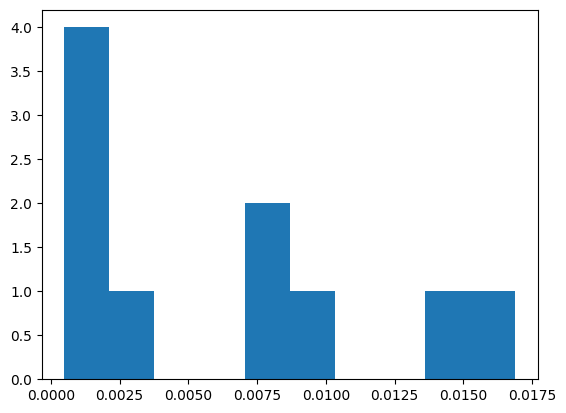

In [134]:
plt.hist(all_rand_scores)
plt.show()

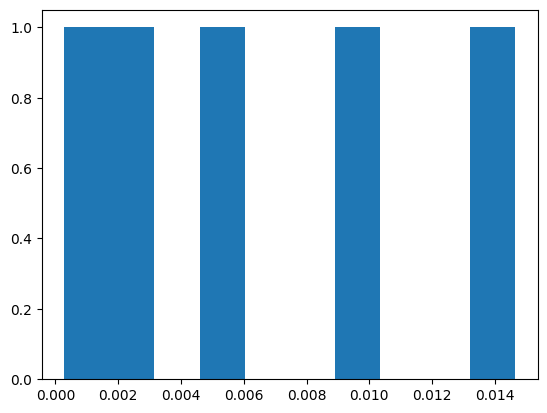

In [135]:
all_rand_scores = []
num_feats = weight_matrix_np.shape[0]
for i in range(5):
    rand_modA_feats = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=num_feats).tolist()
    rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=num_feats).tolist()

    score = svcca(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats], "nd")
    all_rand_scores.append(score)
print(sum(all_rand_scores) / len(all_rand_scores))

plt.hist(all_rand_scores)
plt.show()

In [136]:
sum(all_rand_scores) / len(all_rand_scores)

0.006321775821671194

## remove all corr feats less than 0.9

In [187]:
new_highest_correlations_indices_AB_A = []
new_highest_correlations_indices_AB = []
new_highest_correlations_values_AB = []

ind_A = 0
for ind_B, val in zip(highest_correlations_indices_AB, highest_correlations_values_AB):
    if val > 0.9:
        new_highest_correlations_indices_AB_A.append(ind_A)
        new_highest_correlations_indices_AB.append(ind_B)
        new_highest_correlations_values_AB.append(val)
    ind_A += 1

In [ ]:
len(new_highest_correlations_values_AB)

1076

In [ ]:
len(list(set(new_highest_correlations_indices_AB_A)))

1076

In [ ]:
len(list(set(new_highest_correlations_indices_AB)))

664

In [ ]:
weight_matrix_np[new_highest_correlations_indices_AB_A, :].shape

(1076, 1024)

In [141]:
# unpaired
svcca(weight_matrix_np[:len(new_highest_correlations_indices_AB_A)], weight_matrix_2[:len(new_highest_correlations_indices_AB_A)], "nd")

0.0019257061002588114

In [188]:
svcca(weight_matrix_np[:len(new_highest_correlations_indices_AB_A)], weight_matrix_2[new_highest_correlations_indices_AB, :], "nd")

0.04326762163142002

## single token subspaces

In [ ]:
keyword = "upon"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(svcca(X_subset, Y_subset, "nd"))
print(get_rand_scores(modA_feats, modB_feats))

76
0.056827029408803145
0.08945935028890449


In [ ]:
keyword = "once"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(svcca(X_subset, Y_subset, "nd"))
print(get_rand_scores(modA_feats, modB_feats))

45
0.0272737328880167
0.13166148809220649


In [ ]:
keyword = "she"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(svcca(X_subset, Y_subset, "nd"))
print(get_rand_scores(modA_feats, modB_feats))

380
0.22641098906434773
0.040297706981290135


In [ ]:
keyword = "let"
modB_feats = find_indices_with_keyword(fList_model_B, keyword)
modA_feats = get_values_from_indices(modB_feats, highest_correlations_indices_v1)
X_subset = weight_matrix_np[modA_feats, :]
Y_subset = weight_matrix_2[modB_feats, :]
print(len(X_subset))
print(svcca(X_subset, Y_subset, "nd"))
print(get_rand_scores(modA_feats, modB_feats))

43
0.039652458943790034
0.1276034009549256


## on token actvs

In [ ]:
svcca(reshaped_activations_A[:10000, :], reshaped_activations_B[:10000, :], "nd")

0.00995021963196151

In [ ]:
svcca(reshaped_activations_A, reshaped_activations_B, "nd")